In [1]:
#pip install catboost <- run first time this notebook is executed
#pip install sklearn
#pip install tabulate

In [2]:
#pip install lightgbm

In [3]:
#conda create -n myenvir -y -q Python=3.6
#conda activate myenvir
#conda install -c conda-forge lightgbm

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
from catboost import CatBoostRegressor
import lightgbm as lgb
import datetime
from sklearn import preprocessing
import numpy as np
from matplotlib import pyplot as plt

In [6]:
from IPython.display import HTML, display
import tabulate

In [7]:
df = pd.read_parquet('../data/forecasting_format/dataframe_forecasting_with_features.parquet')

In [35]:
def predict_horizon(model, training_df, test_df, feature_list, num_predictions=8):
    start_period = 0
    end_period = num_predictions
    prediction_list = []
    
    # We generate an encoder for country feature
    #if 'Country' in feature_list:
    #    ns_encoder = preprocessing.LabelEncoder()
    #    training_df['Country'] =  ns_encoder.fit_transform(training_df['Country'])
    
    x_training_df = training_df[feature_list].copy()
    model.train(x_training_df)
    
    # Predicting on test set, while end period is not equal to end of length of test_df
    while end_period <= len(test_df):
        # Collect features from start to end (67 hours) and predict
        features_df = test_df[feature_list][start_period:end_period].copy()
        #if 'Country' in feature_list:
        #    features_df['Country'] = ns_encoder.transform(features_df['Country'])
        #true_df = test_df[['Cases']][start_period:end_period].copy()
        #predictions = model.predict(features_df)
       
        # Add the predicted data
        predicted_df = pd.DataFrame(predictions, columns=['predicted'])
        predicted_df.index = true_df.index.copy()        
        prediction_list.extend(predictions)
        # Move to next period
        start_period += 1
        end_period += 1
    
    test_df = test_df.assign(Predicted=prediction_list)
    return test_df


In [9]:
def MAPE(df,true_column,pred_column):
    true_list = df[true_column].to_numpy()
    pred_list = df[pred_column].to_numpy()

    return np.mean(np.abs((true_list - pred_list) / true_list)) * 100

In [10]:
def true_predicted_fig(true_df, predicted_df, title_str):
    fig,ax = plt.subplots(figsize=[12,4])
    p_t_max = np.max(np.maximum(true_df[:8]['Cases'].values,predicted_df[:8]['Predicted'].values))
    p_t_min = np.min(np.minimum(true_df[:8]['Cases'].values,predicted_df[:8]['Predicted'].values))
    t1 = ax.plot(true_df.index[:8], true_df[:8]['Cases'], 'black')
    ax.set_ylabel('Cases')
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(title_str)
    p1 = ax.plot(predicted_df.index[:8], predicted_df[:8]['Predicted'], 'Red', linewidth=3)
    ax.legend((t1[0], p1[0]), ('True', 'Predicted'), loc=1, frameon=True)

In [11]:
def accumulated_dataframe_column(df_test,cluster_CB_df):
    test_start_value = df_test.loc[df_test.index == datetime.datetime(2020,9,9), 'cases_tot'].values[0]
    cluster_CB_df['Accumulated_Prediction']=0
    cluster_CB_df['Accumulated_Prediction'][0] = test_start_value + cluster_CB_df['Predicted'][0]
    for i in range(1,len(cluster_CB_df)):
        cluster_CB_df['Accumulated_Prediction'][i] = cluster_CB_df['Accumulated_Prediction'][i-1]+cluster_CB_df['Predicted'][i]
    return cluster_CB_df

# Forecasting, traning with all data

## Selecting test countries

In [12]:
Algeria_df = df[df['Country'].isin(['Algeria'])]

In [13]:
test_1_df =  Algeria_df[(Algeria_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Algeria_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [14]:
Belgium_df = df[df['Country'].isin(['Belgium'])]

In [15]:
test_2_df = Belgium_df[(Belgium_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Belgium_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [16]:
Bangladesh_df = df[df['Country'].isin(['Bangladesh'])]

In [17]:
test_3_df =  Bangladesh_df[(Bangladesh_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Bangladesh_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [18]:
Croatia_df = df[df['Country'].isin(['Croatia'])]

In [19]:
test_4_df =  Croatia_df[(Croatia_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Croatia_df.index.date <= datetime.date(2020, 9, 17))].copy()

## Test country 1, Algeria

In [20]:
training_1_df = df[(df.index.date >= datetime.date(2020, 3, 1)) & 
                    (df.index.date <= datetime.date(2020, 9, 9))].copy()

In [21]:
# Generate model
feature_list = ['Month','Day','prev_case']#,'Weekend','cases_tot']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Algeria_CB_df = predict_horizon(model=model, training_df=training_1_df.copy(), 
                                                             test_df=test_1_df.copy(),
                                                             feature_list=feature_list)

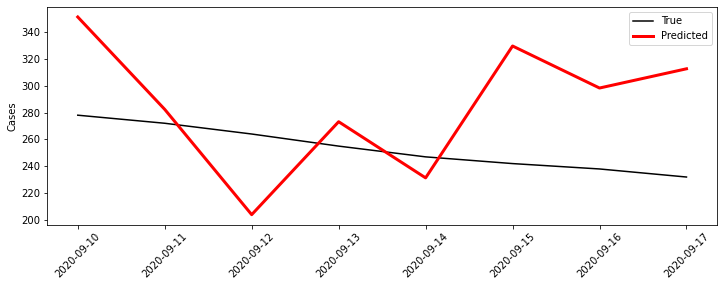

In [22]:
title_str =''
true_predicted_fig(test_1_df,Algeria_CB_df,title_str)

In [23]:
Algeria_CB_df = accumulated_dataframe_column(Algeria_df,Algeria_CB_df)

In [24]:
Algeria_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,278.0,Algeria,47216.0,9,3,0.0,285.0,351.062536,47289
2020-09-11,272.0,Algeria,47488.0,9,4,0.0,278.0,282.333601,47571
2020-09-12,264.0,Algeria,47752.0,9,5,1.0,272.0,204.006052,47775
2020-09-13,255.0,Algeria,48007.0,9,6,1.0,264.0,273.141014,48048
2020-09-14,247.0,Algeria,48254.0,9,0,0.0,255.0,231.373548,48279
2020-09-15,242.0,Algeria,48496.0,9,1,0.0,247.0,329.475308,48608
2020-09-16,238.0,Algeria,48734.0,9,2,0.0,242.0,298.211809,48906
2020-09-17,232.0,Algeria,48966.0,9,3,0.0,238.0,312.523488,49218


Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

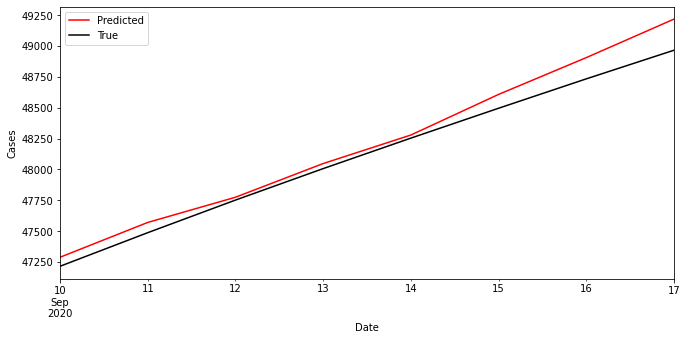

In [25]:
fig = plt.figure()
Algeria_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Algeria_all_data", bbox_inches='tight')

In [26]:
round(MAPE(Algeria_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2017

In [27]:
#Algeria_CB_df.to_parquet('../results/forecasting_results/forecast_with_all_data_algeria.parquet')

## Test country 2, Belgium

In [28]:
training_2_df = df[(df.index.date >= datetime.date(2020, 3, 1)) & 
                    (df.index.date <= datetime.date(2020, 9, 9))].copy()

In [36]:
# Generate model
feature_list = ['Month','Day','prev_case']#,'Weekend','cases_tot']
params= {'iterations': 5000, 'silent': True}
model = lgb#(**params)
Belgium_CB_df = predict_horizon(model=model, training_df=training_2_df.copy(), 
                                                             test_df=test_2_df.copy(),
                                                             feature_list=feature_list)

TypeError: train() missing 1 required positional argument: 'train_set'

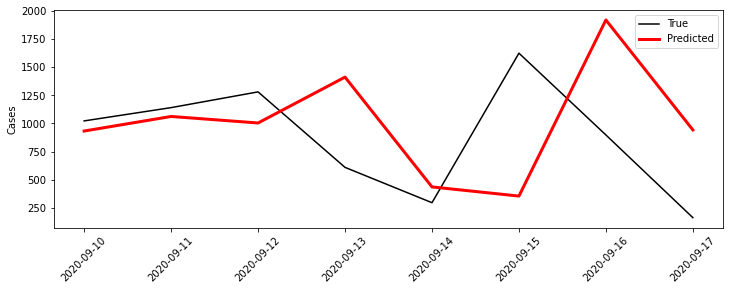

In [28]:
title_str =''
true_predicted_fig(test_2_df,Belgium_CB_df,title_str)

In [29]:
Belgium_CB_df = accumulated_dataframe_column(Belgium_df,Belgium_CB_df)

In [30]:
Belgium_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,1023.0,Belgium,91868.0,9,3,0.0,872.0,932.958781,91777
2020-09-11,1141.0,Belgium,93009.0,9,4,0.0,1023.0,1062.439761,92839
2020-09-12,1281.0,Belgium,94290.0,9,5,1.0,1141.0,1004.474455,93843
2020-09-13,610.0,Belgium,94900.0,9,6,1.0,1281.0,1412.209869,95255
2020-09-14,296.0,Belgium,95196.0,9,0,0.0,610.0,436.154057,95691
2020-09-15,1625.0,Belgium,96821.0,9,1,0.0,296.0,354.752850,96045
2020-09-16,898.0,Belgium,97719.0,9,2,0.0,1625.0,1920.052348,97965
2020-09-17,163.0,Belgium,97882.0,9,3,0.0,898.0,942.962316,98907


Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

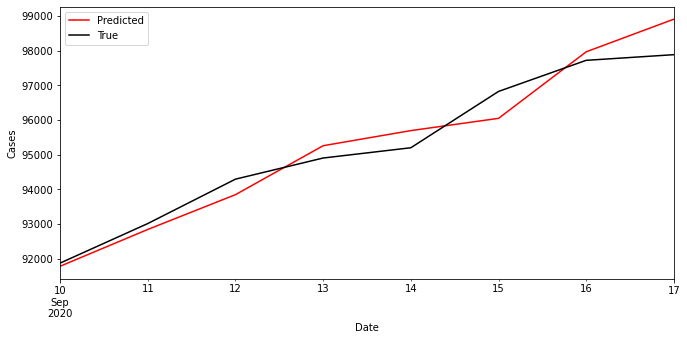

In [31]:
fig = plt.figure()
Belgium_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'],figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Belgium_all_data", bbox_inches='tight')

In [32]:
round(MAPE(Belgium_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.4688

In [33]:
#Belgium_CB_df.to_parquet('../results/forecasting_results/forecast_with_all_data_belgium.parquet')

## Test country 3, Bangladesh

In [34]:
training_3_df = df[(df.index.date >= datetime.date(2020, 3, 1)) & 
                    (df.index.date <= datetime.date(2020, 9, 9))].copy()

In [35]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']#,'Weekend']#,'cases_tot']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Bangladesh_CB_df = predict_horizon(model=model, training_df=training_3_df.copy(), 
                                                             test_df=test_3_df.copy(),
                                                             feature_list=feature_list)



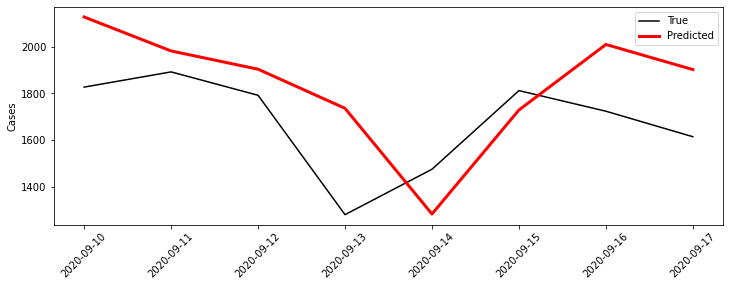

In [36]:
title_str =''
true_predicted_fig(test_3_df,Bangladesh_CB_df,title_str)

In [37]:
Bangladesh_CB_df = accumulated_dataframe_column(Bangladesh_df,Bangladesh_CB_df)

In [38]:
Bangladesh_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,1827.0,Bangladesh,331078.0,9,3,0.0,1892.0,2126.630095,331377
2020-09-11,1892.0,Bangladesh,332970.0,9,4,0.0,1827.0,1981.490455,333358
2020-09-12,1792.0,Bangladesh,334762.0,9,5,1.0,1892.0,1903.535301,335261
2020-09-13,1282.0,Bangladesh,336044.0,9,6,1.0,1792.0,1736.323114,336997
2020-09-14,1476.0,Bangladesh,337520.0,9,0,0.0,1282.0,1284.748762,338281
2020-09-15,1812.0,Bangladesh,339332.0,9,1,0.0,1476.0,1729.270870,340010
2020-09-16,1724.0,Bangladesh,341056.0,9,2,0.0,1812.0,2009.202774,342019
2020-09-17,1615.0,Bangladesh,342671.0,9,3,0.0,1724.0,1901.906773,343920


Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

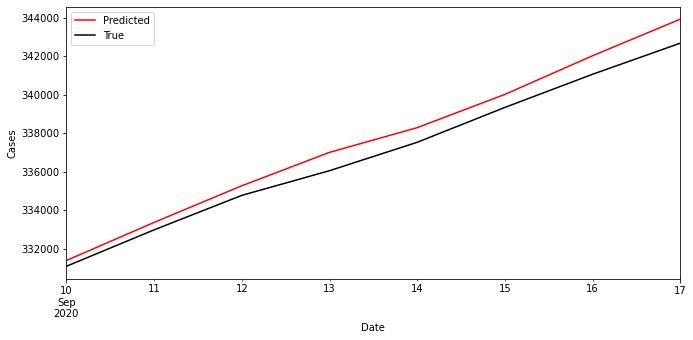

In [39]:
fig = plt.figure()
Bangladesh_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'],figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Bangladesh_all_data", bbox_inches='tight')

In [40]:
round(MAPE(Bangladesh_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.214

In [41]:
#Bangladesh_CB_df.to_parquet('../results/forecasting_results/forecast_with_all_data_bangladesh.parquet')

## Test country 4, Croatia

In [42]:
training_4_df = df[(df.index.date >= datetime.date(2020, 3, 1)) & 
                    (df.index.date <= datetime.date(2020, 9, 9))].copy()

In [43]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']#,'Weekend']#,'cases_tot']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Croatia_CB_df = predict_horizon(model=model, training_df=training_4_df.copy(), 
                                                             test_df=test_4_df.copy(),
                                                             feature_list=feature_list)

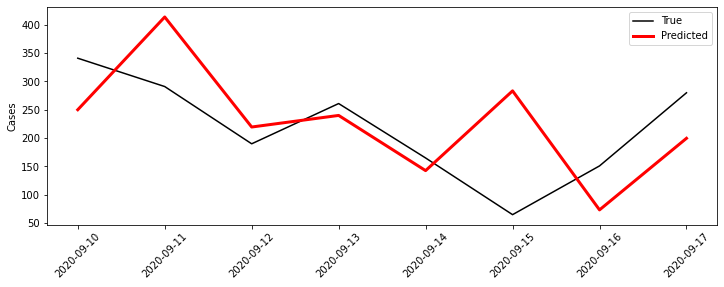

In [44]:
title_str =''
true_predicted_fig(test_4_df,Croatia_CB_df,title_str)

In [45]:
Croatia_CB_df = accumulated_dataframe_column(Croatia_df,Croatia_CB_df)

In [46]:
Croatia_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,341.0,Croatia,12626.0,9,3,0.0,204.0,250.094155,12535
2020-09-11,291.0,Croatia,12917.0,9,4,0.0,341.0,413.708907,12948
2020-09-12,190.0,Croatia,13107.0,9,5,1.0,291.0,219.602410,13167
2020-09-13,261.0,Croatia,13368.0,9,6,1.0,190.0,240.047198,13407
2020-09-14,165.0,Croatia,13533.0,9,0,0.0,261.0,142.693039,13549
2020-09-15,65.0,Croatia,13598.0,9,1,0.0,165.0,283.379278,13832
2020-09-16,151.0,Croatia,13749.0,9,2,0.0,65.0,73.424594,13905
2020-09-17,280.0,Croatia,14029.0,9,3,0.0,151.0,199.698884,14104


Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

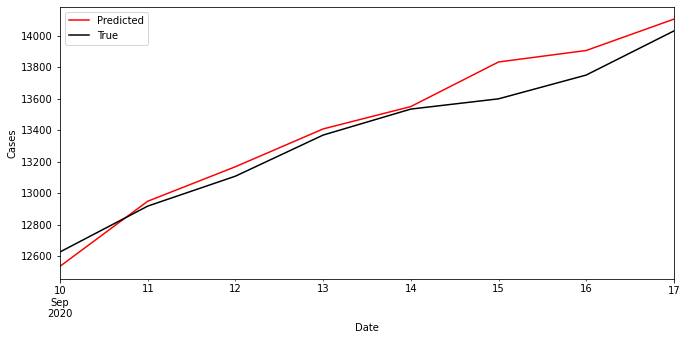

In [47]:
fig = plt.figure()
Croatia_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'],figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Croatia_all_data", bbox_inches='tight')

In [48]:
round(MAPE(Croatia_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.6523

In [49]:
#Croatia_CB_df.to_parquet('../results/forecasting_results/forecast_with_all_data_croatia.parquet')

## Summary:

In [50]:
table = [["Test Country:", "MAPE:"],
        ["Algeria",round(MAPE(Algeria_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Belgium",round(MAPE(Belgium_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Bangladesh",round(MAPE(Bangladesh_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Croatia",round(MAPE(Croatia_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Total MAPE:",round(MAPE(Algeria_CB_df,'cases_tot','Accumulated_Prediction')+
                       MAPE(Croatia_CB_df,'cases_tot','Accumulated_Prediction')+
                       MAPE(Belgium_CB_df,'cases_tot','Accumulated_Prediction')+
                       MAPE(Bangladesh_CB_df,'cases_tot','Accumulated_Prediction'),4)]]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Test Country:,MAPE:
Algeria,0.2017
Belgium,0.4688
Bangladesh,0.214
Croatia,0.6523
Total MAPE:,1.5367
